In [29]:
# Description

# Prediction of the target variable exit_stop_id using the variables 
# datetime, route, direction, and stop_id as predictors. Because the 
# target variable is categorical with several categories and sparse, 
# only levels that appeared at least 500 times in the data were included. 
# The variable datetime denotes the date and was converted to a 3-level 
# categorical. The rest of the variables predictor variables were coded
# as integers. 

# The dataset was divided into a training set (80%) and a test set (20%).

# Algorithms: decision tree, k-NN, Random Forest, Bagging, Gradient Boosting, 
# Kernel ridge regression and Neural network.

# The parameters of the models were checked by search to optimize the 
# accuracy in the test set.
# The accuracy of the algorithms ranged from 40% (k-NN) to 63% (Bagging). 
# The neural network gave good results and further tuning can be done 
# to achieve higher accuracy.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import time

# Read CSV file
data = pd.read_csv('result_20210907.csv')
pd.set_option('display.max_rows', None)

# Υπολογισμός αριθμού εγγραφών για κάθε αρχείο
num_rows_file = len(data)
print(f'Αριθμός δεδομένων πριν την επεξεργασία: {num_rows_file}')

unique_stop_id = data['stop_id'].nunique()
unique_exit_stop_ids = data['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id: {unique_stop_id}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id: {unique_exit_stop_ids}')

# Remove rows where "exit_stop_id" or "stop_id" is empty
data = data.dropna(subset=['exit_stop_id', 'stop_id'])

# Drop unnecessary columns

data_cleaned = data.drop(columns=['GarNr', 'ValidTalonaId', 'TripCompanyCode', 'stop_name', "geometry", "exit_geometry", "exit_stop_name"])

# Transform date and time to categorical variable with 3 levels (Early, Mid-day and Late)

bins = ['00:00:00', '03:00:00', '11:00:00', '17:00:00', '23:59:59']
labels = ['Late', 'Early', 'Mid-Day', 'Late']
s = pd.to_timedelta(pd.to_datetime(data_cleaned['datetime']).dt.time.astype(str))
data_cleaned['datetime'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

# Make exit_stop_id the target variable

if 'exit_stop_id' in data_cleaned.columns:
    data_copy = data_cleaned.copy()
    # Assign 'exit_stop_id' as the target variable
    y = data_copy['exit_stop_id']
    data = data_copy.drop(columns=['exit_stop_id'])

Αριθμός δεδομένων πριν την επεξεργασία: 310848
Διακριτές τιμές στη στήλη stop_id: 1576
Διακριτές τιμές στη στήλη exit_stop_id: 1526


In [31]:
# Identify targets with less that 300 ocurrences and remove them from dataset

df = pd.value_counts(y).to_frame().reset_index()
stop_id_counts = data_copy["exit_stop_id"].value_counts()
stop_ids_to_delete = stop_id_counts[stop_id_counts < 500]

# Remove the rows corresponding to the rarest values

df = data_copy[~data_copy['exit_stop_id'].isin(stop_ids_to_delete.index)]

y = df['exit_stop_id']
data = df.drop(columns=['exit_stop_id'])
print("Δεδομενα μετα τον καθαρισμο:", len(data))

unique_stop_id_updated = data['stop_id'].nunique()
unique_exit_stop_ids_updated = df['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: {unique_stop_id_updated}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: {unique_exit_stop_ids_updated}')


# Convert categories to integers for classification
data["datetime"] = pd.factorize(data["datetime"])[0]
data["route"] = pd.factorize(data["route"])[0]
data["direction"] = pd.factorize(data["direction"])[0]
data["stop_id"] = pd.factorize(data["stop_id"])[0]
y = pd.factorize(y)[0]

# Create training and test subsets

x_train, x_test, y_train, y_test=train_test_split(data, y, test_size=0.20,random_state=0)


# Υπολογισμός ποσοστού για καθεμία από τις κατηγορίες στα καθαρισμένα δεδομένα
category_counts_cleaned = df['datetime'].value_counts(normalize=True) * 100

# Εκτύπωση των ποσοστών για καθεμία από τις κατηγορίες
print(f"Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):")
print(f"Late: {category_counts_cleaned.get('Late', 0):.2f}%")
print(f"Early: {category_counts_cleaned.get('Early', 0):.2f}%")
print(f"Mid-Day: {category_counts_cleaned.get('Mid-Day', 0):.2f}%")

Δεδομενα μετα τον καθαρισμο: 34870
Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: 1110
Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: 38
Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):
Late: 14.94%
Early: 43.95%
Mid-Day: 41.11%


C:\Users\ilian\AppData\Local\Temp\ipykernel_19624\4257896153.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df = pd.value_counts(y).to_frame().reset_index()


In [32]:
# The algorithms that are used are

## Decision tree
## Random Forest
## Bagging
## Gradient Boosting
## Kernel ridge regression
## Neural network

In [33]:
# Decision tree

tree = DecisionTreeClassifier(random_state=2024)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Tree Test Accuracy:", acc)

# Bagging

bagging = BaggingClassifier(n_estimators=200, random_state=2024)
bagging.fit(x_train, y_train)
y_pred = bagging.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Bagging test accuracy score: {score}")

# Random Forest

rf = RandomForestClassifier(n_estimators=10, max_features = 'sqrt', random_state=2024)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"Random Forest test accuracy score: {score}")

# XGBoost
xgboost_model = xgb.XGBClassifier(n_estimators=65, learning_rate=0.1, random_state=2024)
xgboost_model.fit(x_train, y_train) 
y_pred = xgboost_model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f"XGBoost test accuracy score: {score}")

# LightGBM 
lgbm_model = lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=2024, verbose= -1)
lgbm_model.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test) 
score = accuracy_score(y_test, y_pred) 
print(f"LightGBM test accuracy score: {score}")

Tree Test Accuracy: 0.47261256094063664
Bagging test accuracy score: 0.47619730427301404
Random Forest test accuracy score: 0.4648695153427015
XGBoost test accuracy score: 0.4889589905362776
LightGBM test accuracy score: 0.48293662173788354


Decision Tree Results: 
    Depth  Accuracy  Cumulative Time (s)
0       1  0.119874             0.010571
1       2  0.172498             0.024836
2       3  0.215085             0.041224
3       4  0.238170             0.060987
4       5  0.276169             0.081497
5       6  0.312016             0.099051
6       7  0.354746             0.118635
7       8  0.404216             0.139264
8       9  0.433897             0.163509
9      10  0.462289             0.188028
10     11  0.465730             0.217032
11     12  0.469315             0.245277
12     13  0.466734             0.274746
13     14  0.470462             0.304492
14     15  0.466734             0.336498
15     16  0.471896             0.370505
16     17  0.471035             0.403479
17     18  0.473043             0.435025
18     19  0.473186             0.468019
19     20  0.473616             0.499531


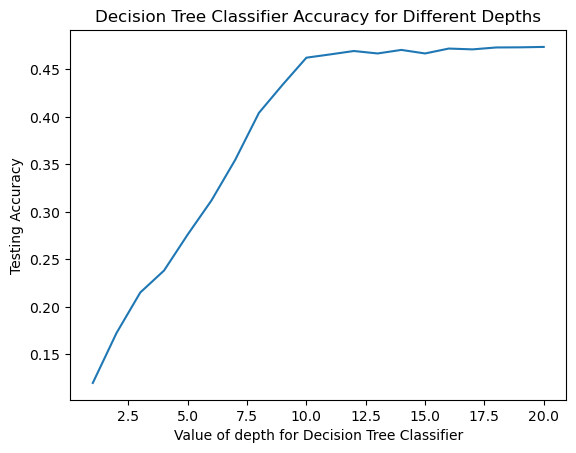

In [34]:
# Decision Tree

import matplotlib.pyplot as plt
%matplotlib inline

scores = []
times = []
total_time = 0
depths = range(1, 21)
for depth in depths:
    start_time = time.time()
    tree = DecisionTreeClassifier(max_depth=depth, random_state=2024)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_dt = pd.DataFrame({'Depth': depths, 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Decision Tree Results: ")
print(df_dt)

plt.plot(depths, scores)
plt.xlabel('Value of depth for Decision Tree Classifier')
plt.ylabel('Testing Accuracy')
plt.title('Decision Tree Classifier Accuracy for Different Depths')
plt.show()

Bagging Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.449957             0.085146
1              2  0.461715             1.221149
2              3  0.461141             2.525923
3              4  0.463292             3.882040
4              5  0.466877             5.367841
5              6  0.465300             7.041476
6              7  0.469888             7.366222
7              8  0.469888             8.266556
8              9  0.469888            10.240828
9             10  0.470032            10.630844
10            11  0.469745            11.633033
11            12  0.471179            13.202807
12            13  0.472182            13.606948
13            14  0.470318            14.609798
14            15  0.474190            16.283507
15            16  0.474620            16.782328
16            17  0.471465            17.833885
17            18  0.472469            18.299795
18            19  0.474620            18.786528
19            20  0.47

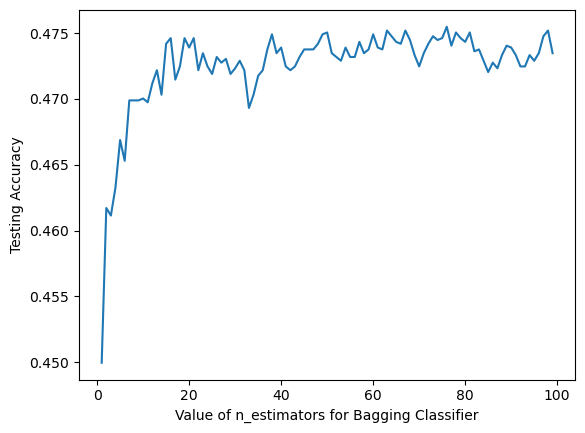

In [35]:
## Bagging for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    bagging = BaggingClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    bagging.fit(x_train, y_train)
    y_pred = bagging.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_bagging = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Bagging Results: ")
print(df_bagging)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Bagging Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

Random Forest Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.441640             0.124553
1              2  0.450817             0.180248
2              3  0.454545             0.243538
3              4  0.458704             0.304686
4              5  0.463292             0.368160
5              6  0.462289             0.430385
6              7  0.465443             0.491759
7              8  0.466160             0.569158
8              9  0.464009             0.662945
9             10  0.464726             0.757138
10            11  0.464296             0.848237
11            12  0.465586             0.942083
12            13  0.465730             1.050256
13            14  0.464726             1.157124
14            15  0.468598             1.267309
15            16  0.467737             1.401745
16            17  0.465300             1.545520
17            18  0.466877             1.701858
18            19  0.468884             1.857522
19            20

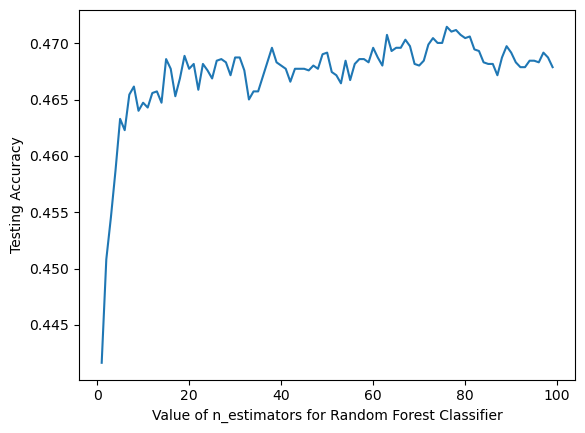

In [36]:
## Random Forest for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    rfc = RandomForestClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_rfc = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Random Forest Results: ")
print(df_rfc)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

XGBoost Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.447233             0.062863
1              2  0.456266             0.143203
2              3  0.461858             0.239834
3              4  0.463292             0.362377
4              5  0.466590             0.510218
5              6  0.469315             0.687047
6              7  0.469601             0.890172
7              8  0.471465             1.134431
8              9  0.472756             1.391555
9             10  0.474046             1.672565
10            11  0.474907             1.982846
11            12  0.475767             2.329788
12            13  0.475337             2.704350
13            14  0.475480             3.117279
14            15  0.475050             3.533666
15            16  0.476914             3.978907
16            17  0.478778             4.458575
17            18  0.478778             4.958355
18            19  0.479065             5.559948
19            20  0.47

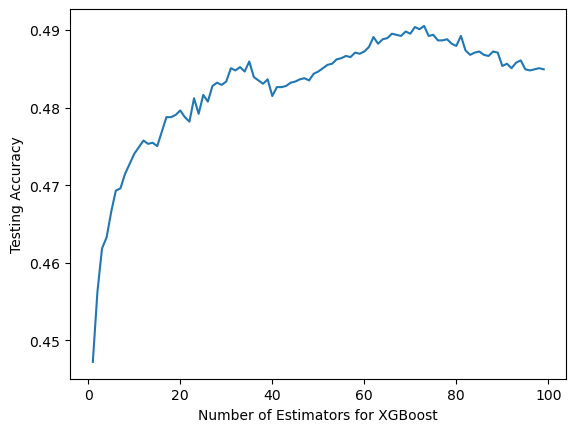

In [37]:
# List to store accuracy scores

xgboost_scores = []
xgboost_times = []
total_time = 0

for n in range(1, 100):
    start_time = time.time()
    xgboost_model = xgb.XGBClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbosity=0)
    xgboost_model.fit(x_train, y_train)
    y_pred = xgboost_model.predict(x_test)
    xgboost_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    xgboost_times.append(total_time)  # Store cumulative time

df_xgboost = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': xgboost_scores, 'Cumulative Time (s)': xgboost_times})
print("XGBoost Results: ")
print(df_xgboost)

plt.plot(range(1, 100), xgboost_scores)
plt.xlabel('Number of Estimators for XGBoost')
plt.ylabel('Testing Accuracy')
plt.show()

LightGBM Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.430886             0.058362
1              2  0.465873             0.128968
2              3  0.473616             0.220199
3              4  0.473760             0.332002
4              5  0.474333             0.468158
5              6  0.475194             0.623291
6              7  0.476054             0.803297
7              8  0.477058             1.016523
8              9  0.479495             1.258745
9             10  0.479208             1.534022
10            11  0.478348             1.840575
11            12  0.479495             2.158329
12            13  0.480929             2.508088
13            14  0.480786             2.889416
14            15  0.480929             3.296227
15            16  0.481359             3.717175
16            17  0.481503             4.167032
17            18  0.481073             4.642311
18            19  0.482363             5.123536
19            20  0.4

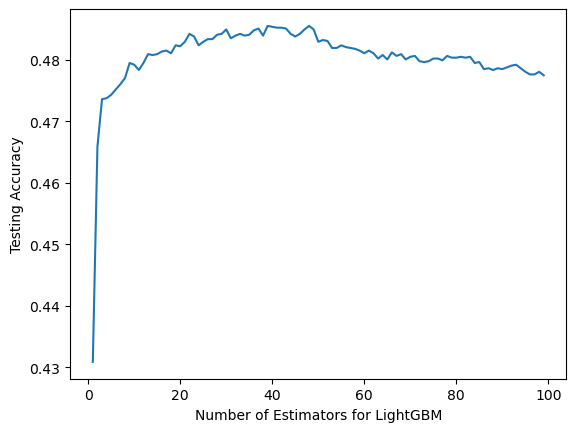

In [38]:
# List to store accuracy scores
lightgbm_times = []
lightgbm_scores = []
total_time = 0

for n in range(1, 100):
    start_time = time.time()
    lgbm_model = lgb.LGBMClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbose=-1)
    lgbm_model.fit(x_train, y_train)
    y_pred = lgbm_model.predict(x_test)
    lightgbm_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    lightgbm_times.append(total_time)  # Store cumulative time

df_lgbm = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': lightgbm_scores, 'Cumulative Time (s)': lightgbm_times})
print("LightGBM Results: ")
print(df_lgbm)

plt.plot(range(1, 100), lightgbm_scores)
plt.xlabel('Number of Estimators for LightGBM')
plt.ylabel('Testing Accuracy')
plt.show()

(24409, 4) (5230, 4) (5231, 4) (24409, 38) (5230, 38) (5231, 38)
Epoch 1/65
814/814 [==============================] - 1s 1ms/step - loss: 3.1307 - accuracy: 0.1414 - val_loss: 2.9745 - val_accuracy: 0.1608
Epoch 2/65
814/814 [==============================] - 1s 1ms/step - loss: 2.9113 - accuracy: 0.1737 - val_loss: 2.8600 - val_accuracy: 0.1935
Epoch 3/65
814/814 [==============================] - 1s 1ms/step - loss: 2.8063 - accuracy: 0.1974 - val_loss: 2.7539 - val_accuracy: 0.2124
Epoch 4/65
814/814 [==============================] - 1s 1ms/step - loss: 2.7041 - accuracy: 0.2098 - val_loss: 2.6407 - val_accuracy: 0.2187
Epoch 5/65
814/814 [==============================] - 1s 1ms/step - loss: 2.5981 - accuracy: 0.2278 - val_loss: 2.5437 - val_accuracy: 0.2501
Epoch 6/65
814/814 [==============================] - 1s 1ms/step - loss: 2.4927 - accuracy: 0.2499 - val_loss: 2.4415 - val_accuracy: 0.2740
Epoch 7/65
814/814 [==============================] - 1s 1ms/step - loss: 2.3947 - 

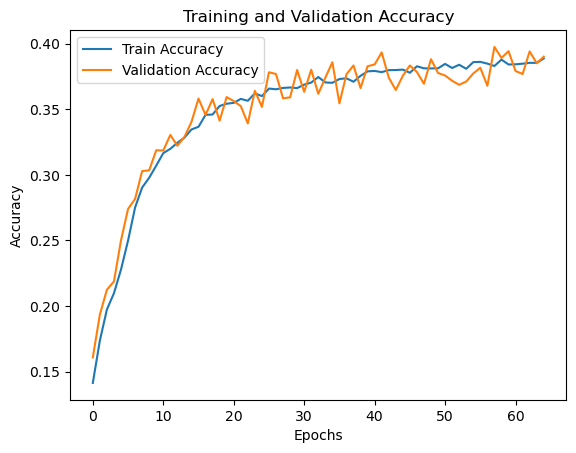

In [39]:
## Neural network 

from keras.models import Sequential
from keras.layers import Dense
from keras import backend

dummy_y = to_categorical(y, num_classes=None)
scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(data, dummy_y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

model = Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_initializer="normal"),
    Dense(64, activation='relu', kernel_initializer="normal"),
    Dense(unique_exit_stop_ids_updated, activation='softmax', kernel_initializer="normal"),  # εξοδος το unique_exit_stop_ids_updated (δηλ οι Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο)
])


# Create the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=30, epochs=65,
          validation_data=(X_val, Y_val))

model.evaluate(X_test, Y_test)[1]

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Plot the accuracy
plot_accuracy(hist)